# PyTorch: Aprendiendo Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.1)

import os
import pickle
import datetime
from collections import defaultdict

In [2]:
# 1.2)

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [3]:
# 1.3)

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [4]:
# 1.4)
#import google.colab
#from google.colab import files

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores al rango [0,1]) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [5]:
# 2.1)

PATH = 'FashionMNIST/'
BATCH_SIZE = 64

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  
])

train_data = datasets.FashionMNIST(PATH, train=True, download=True, transform=transform)
valid_data = datasets.FashionMNIST(PATH,train=False, download=True, transform=transform)

In [6]:
len(train_data), len(valid_data)

(60000, 10000)

In [7]:
img_t, _ = train_data[0]

In [8]:
imgs = torch.stack([img_t for img_t, _ in train_data], dim=1)
imgs.shape

torch.Size([1, 60000, 28, 28])

In [9]:
imgs.view(1, -1).mean(dim=1)

tensor([0.0001])

In [10]:
imgs.view(1, -1).std(dim=1)

tensor([1.0001])

In [11]:
trainloader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)

validloader = torch.utils.data.DataLoader(valid_data, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=True)

In [12]:
imgs, label = train_data[0]

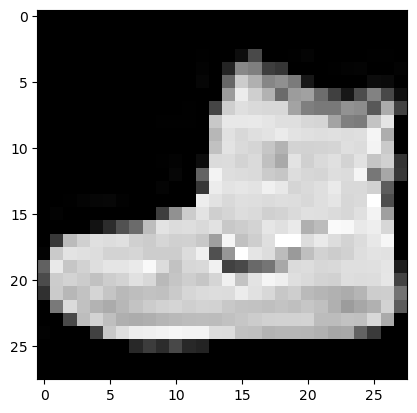

In [13]:
plt.imshow(imgs.squeeze(), cmap='gray')

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html?highlight=nn%20crossentropyloss

https://ryanwingate.com/intro-to-machine-learning/deep-learning-with-pytorch/classifying-fashion-mnist/

Deep Learning with PyTorch, Capitulo 7

In [14]:
labels_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

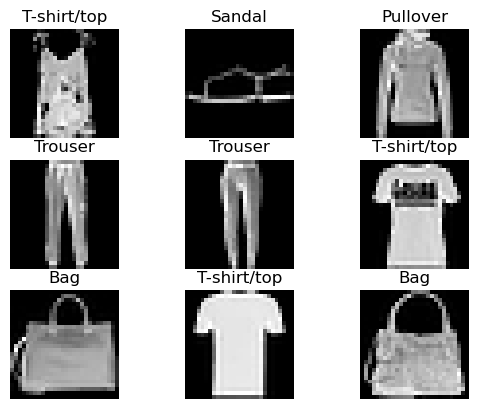

In [15]:
figure = plt.figure()
cols, rows = 3,3

for i in range(1, cols*rows+1):
    j = torch.randint(len(train_data), size=(1,)).item()
    image, label = train_data[j]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_names[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [16]:
# 3.1)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=100, shuffle=True)

In [17]:
# 3.2)

len(train_loader.dataset), len(train_loader)

(60000, 600)

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [18]:
# 4)

class NeuralNetwork(nn.Module):
    def __init__(self, n1, n2, p=0.2):
        super(NeuralNetwork, self).__init__()
        # Capa 0
        self.flatten = nn.Flatten()     #
        
        # Capa 1
        self.fc1 = nn.Linear(28*28, n1) # fully connected
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

        # Capa 2
        self.fc2 = nn.Linear(n1, n2)    # fully connected
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

        # Capa 3        
        self.fc3 = nn.Linear(n2, 10)    # fully connected

    def forward(self, x):
        # Capa 0
        x = self.flatten(x)

        # Capa 1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Capa 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Capa 3
        x = self.fc3(x)
        return x

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [19]:
# 5.1)
def train_model(dataloader, model, loss_fn, optimizer):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0
    num_processed_samples = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        batch_size = len(X)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_avrg_loss = loss.item()
        sum_batch_avrg_loss += batch_avrg_loss
        sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
        num_processed_samples += batch_size

        if batch % max(num_batches // 10, 1) == 0:
            print(f'Batch {batch:>5d} | Loss: {batch_avrg_loss:.6f} | '
                  f'Processed: {100 * num_processed_samples / num_samples:.2f}%')

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    return avg_loss, precision

# 5.2)
def valid_model(dataloader, model, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_batch_avrg_loss = 0
    sum_correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            sum_batch_avrg_loss += loss.item()
            sum_correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()

    avg_loss = sum_batch_avrg_loss / num_batches
    precision = sum_correct / num_samples
    print(f'Validation | Precision: {100 * precision:.1f}% | Avg Loss: {avg_loss:.6f}')
    return avg_loss, precision

In [20]:
# 5.3)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)


# 5.4)
loss_fn = nn.CrossEntropyLoss()


# 5.5)
lr = 1e-3


# 5.6)
n1 = 128
n2 = 64
p = 0.2
model = NeuralNetwork(n1, n2, p=p)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# 5.7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 5.9)
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}\n' + '-' * 20)
    
    train_avg_loss, train_precision = train_model(train_loader, model, loss_fn, optimizer)
    valid_avg_loss, valid_precision = valid_model(valid_loader, model, loss_fn)
    
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print('Entranamiento completo')

Epoch 1
--------------------
Batch     0 | Loss: 2.287950 | Processed: 0.11%
Batch    93 | Loss: 2.265323 | Processed: 10.03%
Batch   186 | Loss: 2.185581 | Processed: 19.95%
Batch   279 | Loss: 2.173590 | Processed: 29.87%
Batch   372 | Loss: 2.118922 | Processed: 39.79%
Batch   465 | Loss: 2.040490 | Processed: 49.71%
Batch   558 | Loss: 1.926057 | Processed: 59.63%
Batch   651 | Loss: 1.949969 | Processed: 69.55%
Batch   744 | Loss: 1.816591 | Processed: 79.47%
Batch   837 | Loss: 1.728029 | Processed: 89.39%
Batch   930 | Loss: 1.642599 | Processed: 99.31%
Validation | Precision: 55.0% | Avg Loss: 1.656110
Epoch 2
--------------------
Batch     0 | Loss: 1.710871 | Processed: 0.11%
Batch    93 | Loss: 1.531211 | Processed: 10.03%
Batch   186 | Loss: 1.640338 | Processed: 19.95%
Batch   279 | Loss: 1.599113 | Processed: 29.87%
Batch   372 | Loss: 1.545923 | Processed: 39.79%
Batch   465 | Loss: 1.502268 | Processed: 49.71%
Batch   558 | Loss: 1.231749 | Processed: 59.63%
Batch   651

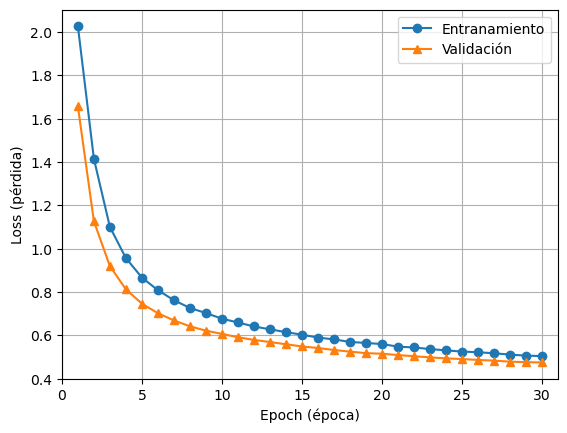

In [31]:
# 5.10)

plt.xlabel('Epoch (época)')
plt.ylabel('Loss (pérdida)')

plt.plot(range(1, len(list_train_avg_loss)+1), list_train_avg_loss, label='Entranamiento', marker='o')
plt.plot(range(1, len(list_valid_avg_loss)+1), list_valid_avg_loss, label='Validación', marker='^')


plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()

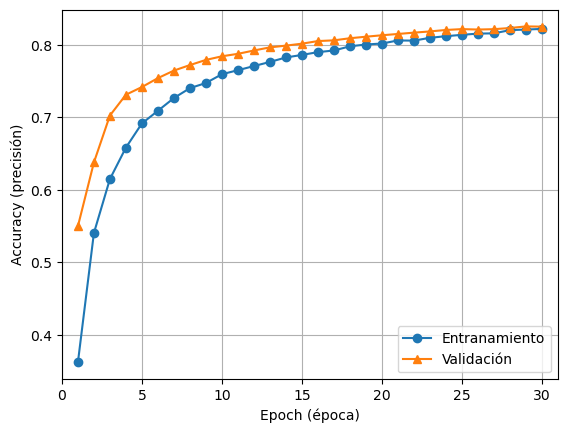

In [32]:
plt.xlabel('Epoch (época)')
plt.ylabel('Accuracy (precisión)')

plt.plot(range(1, len(list_train_precision)+1), list_train_precision, label='Entranamiento', marker='o')
plt.plot(range(1, len(list_valid_precision)+1), list_valid_precision, label='Validación', marker='^')

plt.xlim(0, 31)
#plt.ylim(0.4, 2.2)
plt.grid()
plt.legend()
plt.show()